In [29]:
import yfinance as yf
import numpy as np
import pandas as pd
import os
import datetime
from datetime import datetime, time, timedelta, timezone
from concurrent import futures
from pandas import DataFrame
import pandas_datareader.data as web
import pymongo
import requests_cache
import time
import pytz
import mplfinance as mpf

In [6]:
# Original start date in Eastern Time (UTC-5)
start_date_et = datetime(2023, 10, 1, 10, 0, tzinfo=timezone(timedelta(hours=-5)))
end_date_et = datetime(2023, 11, 1, 10, 0, tzinfo=timezone(timedelta(hours=-5)))

# Convert to UTC
start_date_utc = start_date_et.astimezone(timezone.utc)
end_date_utc = end_date_et.astimezone(timezone.utc)

print(start_date_utc)
print(end_date_utc)

2023-10-01 15:00:00+00:00
2023-11-01 15:00:00+00:00


In [7]:
btc = yf.Ticker("BTC-USD")

In [11]:
# BTC
btc_df = btc.history(start=start_date_utc, end=end_date_utc, interval="15m")# Fetch data for S&P 500 index

In [14]:
columns_list = btc_df.columns.tolist()
print(columns_list)

['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']


In [15]:
# Drop 'Dividends' and 'Stock Splits' columns
btc_df = btc_df.drop(columns=['Dividends', 'Stock Splits'])

In [23]:
# Trends
intervals_per_hour = 4
btc_df['d1H'] = btc_df['Close'] - btc_df['Close'].shift(1 * intervals_per_hour)
btc_df['d3H'] = btc_df['Close'] - btc_df['Close'].shift(3 * intervals_per_hour)
btc_df['d6H'] = btc_df['Close'] - btc_df['Close'].shift(6 * intervals_per_hour)
btc_df['d1D'] = btc_df['Close'] - btc_df['Close'].shift(24 * intervals_per_hour)
btc_df['d7D'] = btc_df['Close'] - btc_df['Close'].shift(7 * 24 * intervals_per_hour)

In [16]:
# Calculate rolling averages
# 1 hour (4 intervals of 15 minutes), 6 hours (24 intervals), 12 hours (48 intervals), 1 day (96 intervals), 1 week (672 intervals)
intervals_per_hour = 4
btc_df['Close_rolling_1h'] = btc_df['Close'].rolling(window=1*intervals_per_hour).mean()
btc_df['Close_rolling_6h'] = btc_df['Close'].rolling(window=6*intervals_per_hour).mean()
btc_df['Close_rolling_12h'] = btc_df['Close'].rolling(window=12*intervals_per_hour).mean()
btc_df['Close_rolling_1d'] = btc_df['Close'].rolling(window=24*intervals_per_hour).mean()
btc_df['Close_rolling_1w'] = btc_df['Close'].rolling(window=7*24*intervals_per_hour).mean()

In [24]:
print(btc_df.head())


                                   Open          High           Low  \
Datetime                                                              
2023-10-01 15:00:00+00:00  27122.312500  27144.205078  27122.312500   
2023-10-01 15:15:00+00:00  27136.244141  27144.171875  27119.367188   
2023-10-01 15:30:00+00:00  27137.406250  27145.894531  27135.216797   
2023-10-01 15:45:00+00:00  27138.175781  27158.505859  27137.410156   
2023-10-01 16:00:00+00:00  27156.275391  27157.417969  27145.205078   

                                  Close    Volume  Close_rolling_1h  \
Datetime                                                              
2023-10-01 15:00:00+00:00  27135.546875  12143616               NaN   
2023-10-01 15:15:00+00:00  27136.126953    475136               NaN   
2023-10-01 15:30:00+00:00  27137.972656    932352               NaN   
2023-10-01 15:45:00+00:00  27156.640625         0      27141.571777   
2023-10-01 16:00:00+00:00  27157.417969         0      27147.039551   

    

In [25]:
# for simplicity lets just trash NaN
btc = btc_df.dropna().copy()

In [26]:
btc['Current'] = btc['High'] - btc['Low']

In [27]:
btc.head(2)

,Open,High,Low,Close,Volume,Close_rolling_1h,Close_rolling_6h,Close_rolling_12h,Close_rolling_1d,Close_rolling_1w,d1H,d3H,d6H,d1D,d7D,Current
Datetime,,,,,,,,,,,,,,,,
2023-10-08 15:00:00+00:00,27954.294922,27961.107422,27940.820312,27961.107422,392704,27936.194824,27881.455729,27922.338379,27942.575846,27722.693906,25.962891,118.890625,18.304688,-6.640625,825.560547,20.287109
2023-10-08 15:15:00+00:00,27951.169922,27951.169922,27926.150391,27930.931641,19564032,27946.081055,27881.691813,27919.019368,27942.096537,27723.876651,39.544922,62.349609,5.666016,-46.013672,794.804688,25.019531


In [28]:
columns_list = btc.columns.tolist()
print(columns_list)

['Open', 'High', 'Low', 'Close', 'Volume', 'Close_rolling_1h', 'Close_rolling_6h', 'Close_rolling_12h', 'Close_rolling_1d', 'Close_rolling_1w', 'd1H', 'd3H', 'd6H', 'd1D', 'd7D', 'Current']


In [31]:
# Print the start and end times for each dataframe
print("BTC DataFrame Start:", btc.index.min(), "End:", btc.index.max())

# Print the number of rows
print("BTC DataFrame Rows:", len(btc))

BTC DataFrame Start: 2023-10-08 15:00:00+00:00 End: 2023-11-01 14:45:00+00:00
BTC DataFrame Rows: 2299


In [36]:
# Assuming btc_df is your dataframe and has a datetime index
# Filter the dataframe for the period from 2023-10-22 to 2023-10-29
filtered_btc_df = btc['2023-10-27':'2023-10-28'].copy()

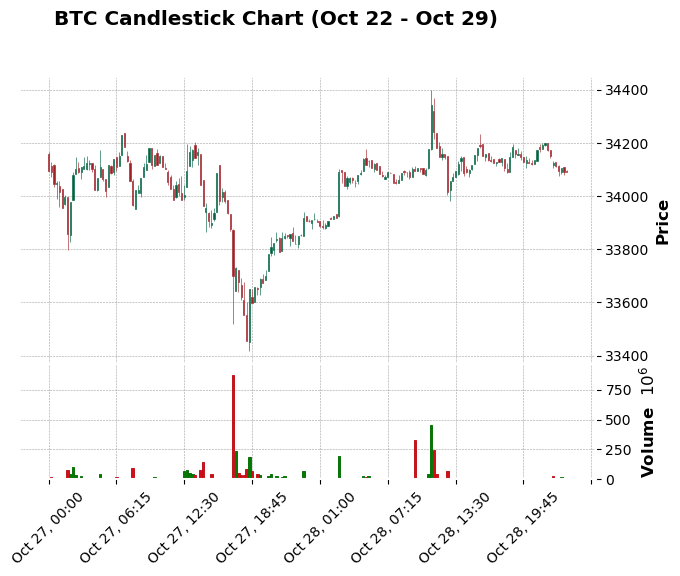

In [37]:
# Ensure that the index of btc_df is a datetime index
filtered_btc_df['Timestamp'] = pd.to_datetime(filtered_btc_df.index)
filtered_btc_df.set_index('Timestamp', inplace=True)

# Create a candlestick chart for the filtered data
mpf.plot(filtered_btc_df, type='candle', style='charles', volume=True, title='BTC Candlestick Chart (Oct 22 - Oct 29)')

In [38]:
# so lets just make it work now
# to start: if the current rate is steeper (getting bigger faster) than the 3 hour rate buy and record the buy price
# if it gains more than 10% sell and bank the profit
# if there's a fast enough drop print a warning (like call me ha)

In [49]:
'''Class TradingBot:
Attributes:
bank_account: To track the balance.
holding: To track whether the bot currently holds BTC.
buy_price: The price at which the bot last bought BTC.
ledger: A list (or another suitable data structure) to record transaction details.
Methods:
__init__: Constructor to initialize the bank account, holding status, buy price, and ledger.
evaluate_buy: To check if the current rate's steepness exceeds the 3-hour rate and decide whether to buy.
evaluate_sell: To check if the profit exceeds 10% and decide whether to sell.
record_transaction: To record the details of each transaction in the ledger.
print_warning: To print a warning in case of a fast enough drop.
apply_to_data: To apply the bot's logic to a dataframe and simulate trading.

The bot checks if there's a drop of more than 2% in the closing price compared to the previous 15-minute interval's closing price.
If such a drop is detected, the print_warning method is called, printing a warning message with the timestamp and the rate of the drop.
This check is performed only if the bot is currently holding BTC (i.e., after a buy and before a sell).


Invest a Fixed Amount ($100) Per Trade: Instead of investing the entire bank account, the bot will only invest $100 in each trade.
Print a Warning if the Bank Account Gets Below $200: Add a check to print a warning if the bank account balance falls below $200.
Handle NaN Values: Ensure the bot skips rows with NaN values to avoid erroneous calculations.
Print an Alert for NaN Values: Print an alert when encountering a row with NaN values.

'''

"Class TradingBot:\nAttributes:\nbank_account: To track the balance.\nholding: To track whether the bot currently holds BTC.\nbuy_price: The price at which the bot last bought BTC.\nledger: A list (or another suitable data structure) to record transaction details.\nMethods:\n__init__: Constructor to initialize the bank account, holding status, buy price, and ledger.\nevaluate_buy: To check if the current rate's steepness exceeds the 3-hour rate and decide whether to buy.\nevaluate_sell: To check if the profit exceeds 10% and decide whether to sell.\nrecord_transaction: To record the details of each transaction in the ledger.\nprint_warning: To print a warning in case of a fast enough drop.\napply_to_data: To apply the bot's logic to a dataframe and simulate trading.\n\nThe bot checks if there's a drop of more than 2% in the closing price compared to the previous 15-minute interval's closing price.\nIf such a drop is detected, the print_warning method is called, printing a warning messa

In [48]:
class TradingBot:
    def __init__(self):
        self.bank_account = 1000  # Starting amount in the bank account
        self.holding = False
        self.buy_price = None
        self.ledger = []
        self.total_trades = 0
        self.total_profit = 0
        self.investment_per_trade = 100

    def evaluate_buy(self, current_rate, rate_3h):
        return current_rate > rate_3h

    def evaluate_sell(self, current_price):
        if self.holding and ((current_price / self.buy_price) - 1) >= 0.1:
            return True
        return False

    def record_transaction(self, time, action, price, profit=None, reason=''):
        self.ledger.append({'time': time, 'action': action, 'price': price, 'profit': profit, 'reason': reason})
        self.total_trades += 1
        if profit:
            self.total_profit += profit

    def print_warning(self, message):
        print(f"Warning: {message}")

    def apply_to_data(self, df):
        for index, row in df.iterrows():
            # Skip rows with NaN values
            if row.isnull().any():
                self.print_warning(f"NaN value detected at {index}. Skipping row.")
                continue

            current_rate = row['Current']
            rate_3h = row['d3H']
            current_price = row['Close']

            if not self.holding and self.evaluate_buy(current_rate, rate_3h):
                if self.bank_account >= self.investment_per_trade:
                    self.holding = True
                    self.buy_price = current_price
                    self.bank_account -= self.investment_per_trade
                    self.record_transaction(index, 'buy', current_price, reason='Rate steeper than 3H rate')
                elif self.bank_account < 200:
                    self.print_warning(f"Account balance below $200 at {index}.")
            elif self.holding and self.evaluate_sell(current_price):
                profit = (current_price - self.buy_price) * (self.investment_per_trade / self.buy_price)
                self.bank_account += self.investment_per_trade + profit
                self.holding = False
                self.record_transaction(index, 'sell', current_price, profit=profit, reason='Gained more than 10%')

        # Print total trades and total profit/loss
        print(f"Total trades: {self.total_trades}")
        print(f"Total profit/loss: {self.total_profit}")

        return self.ledger

In [59]:
# Initialize the bot
bot = TradingBot()

In [60]:
#test data
btc_df_test = btc.copy()

In [61]:
# Print the start and end times for each dataframe
print("BTC DataFrame Start:", btc_df_test.index.min(), "End:", btc_df_test.index.max())

# Print the number of rows
print("BTC DataFrame Rows:", len(btc_df_test))

BTC DataFrame Start: 2023-10-08 15:00:00+00:00 End: 2023-11-01 14:45:00+00:00
BTC DataFrame Rows: 2299


In [62]:
# Ensure that the index of btc_df is a datetime index
btc_df_test['Timestamp'] = pd.to_datetime(btc_df_test.index)
btc_df_test.set_index('Timestamp', inplace=True)

In [64]:
# Apply the bot to a section of the dataframe (for example, 'btc_df')
bot.apply_to_data(btc_df_test['2023-10-08':'2023-11-01'])

Total trades: 5
Total profit/loss: 21.95522355684984


[{'time': Timestamp('2023-10-10 00:00:00+0000', tz='UTC'),
  'action': 'buy',
  'price': 27583.82421875,
  'profit': None,
  'reason': 'Rate steeper than 3H rate'},
 {'time': Timestamp('2023-10-23 01:15:00+0000', tz='UTC'),
  'action': 'sell',
  'price': 30391.517578125,
  'profit': 10.178767588964263,
  'reason': 'Gained more than 10%'},
 {'time': Timestamp('2023-10-23 06:45:00+0000', tz='UTC'),
  'action': 'buy',
  'price': 30705.150390625,
  'profit': None,
  'reason': 'Rate steeper than 3H rate'},
 {'time': Timestamp('2023-10-23 22:30:00+0000', tz='UTC'),
  'action': 'sell',
  'price': 34321.12890625,
  'profit': 11.776455967885578,
  'reason': 'Gained more than 10%'},
 {'time': Timestamp('2023-10-24 01:30:00+0000', tz='UTC'),
  'action': 'buy',
  'price': 33749.5546875,
  'profit': None,
  'reason': 'Rate steeper than 3H rate'}]

In [65]:
# Check the ledger for transactions
print(bot.ledger)


[{'time': Timestamp('2023-10-10 00:00:00+0000', tz='UTC'), 'action': 'buy', 'price': 27583.82421875, 'profit': None, 'reason': 'Rate steeper than 3H rate'}, {'time': Timestamp('2023-10-23 01:15:00+0000', tz='UTC'), 'action': 'sell', 'price': 30391.517578125, 'profit': 10.178767588964263, 'reason': 'Gained more than 10%'}, {'time': Timestamp('2023-10-23 06:45:00+0000', tz='UTC'), 'action': 'buy', 'price': 30705.150390625, 'profit': None, 'reason': 'Rate steeper than 3H rate'}, {'time': Timestamp('2023-10-23 22:30:00+0000', tz='UTC'), 'action': 'sell', 'price': 34321.12890625, 'profit': 11.776455967885578, 'reason': 'Gained more than 10%'}, {'time': Timestamp('2023-10-24 01:30:00+0000', tz='UTC'), 'action': 'buy', 'price': 33749.5546875, 'profit': None, 'reason': 'Rate steeper than 3H rate'}]
